In [ ]:
#Khai báo thư viện.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")
import warnings
warnings.filterwarnings('ignore')  # Tắt tất cả các cảnh báo

# **I. Xác định vấn đề.**

- Vấn đề cần giải quyết:
  + Phê duyệt khoản vay.
  + Thuộc dạng phân cụm( Classification)
  + Phương pháp máy học: học có giám sát( Supervised learning).

In [ ]:
#Nhập dữ liệu.
df_test = pd.read_csv(r'/content/test.csv')
df_train_source = pd.read_csv(r'/content/train.csv')

In [ ]:
df_train = df_train_source.copy()

In [ ]:
df_train.shape

(614, 13)

In [ ]:
df_train.count()

Loan_ID              614
Gender               601
Married              611
Dependents           599
Education            614
Self_Employed        582
ApplicantIncome      614
CoapplicantIncome    614
LoanAmount           592
Loan_Amount_Term     600
Credit_History       564
Property_Area        614
Loan_Status          614
dtype: int64

- Tài nguyên:
 + Dữ liệu gồm 614 dòng và 14 cột.

- Ý nghĩa các cột:
 + 'Loan_ID': Mã định danh duy nhất cho mỗi khoản vay. Mỗi khoản vay sẽ có một mã số riêng biệt.
 + 'Gender': Giới tính của người nộp đơn. Thông thường, giá trị có thể là 'Male' (Nam) hoặc 'Female' (Nữ).
 + 'Married': Tình trạng hôn nhân của người nộp đơn. Giá trị thường là 'Yes' (Đã kết hôn) hoặc 'No' (Chưa kết hôn).
 + 'Dependents': Số lượng người phụ thuộc mà người nộp đơn phải chu cấp. Giá trị có thể là số nguyên như '0', '1', '2', hoặc '3+' (nhiều hơn 3).
 + 'Education': Trình độ học vấn của người nộp đơn. Giá trị là 'Graduate' (Tốt nghiệp đại học) hoặc 'Not Graduate' (Chưa tốt nghiệp đại học).
 + Self_Employed: Tình trạng tự làm chủ của người nộp đơn. Giá trị là 'Graduate' (Tự làm chủ) hoặc 'Not Graduate' (Không tự làm chủ).
 + 'ApplicantIncome': Thu nhập của người nộp đơn.
 + 'CoapplicantIncome': Thu nhập của người đồng nộp đơn (nếu có).
 + 'LoanAmount': Số tiền vay mà người nộp đơn yêu cầu.
 + 'Loan_Amount_Term': Thời hạn vay theo tháng.
 + 'Credit_History': Lịch sử tín dụng của người nộp đơn. Giá trị là 1 (Có lịch sử tín dụng tốt) hoặc 0 (Không có lịch sử tín dụng tốt).
 + 'Property_Area': Khu vực tài sản thế chấp. Giá trị là 'Urban' (Thành thị), 'Semiurban' (Bán thành thị), hoặc 'Rural' (Nông thôn).
 + 'Loan_Status': Tình trạng chấp thuận khoản vay. Giá trị là 'Y' (Được chấp thuận) hoặc 'N' (Bị từ chối).

# **II. Tiền xử lý dữ liệu.**

## **1. Xử lý missing values và outlier**

### **1.1 Xử lý missing values bằng cách điền giá trị phổ biến nhất.**

In [ ]:
# Tìm giá trị phổ biến nhất và điền vào các giá trị khuyết khiếu
mode_train = df_train['Gender'].mode()[0]
df_train['Gender'].fillna(mode_train, inplace=True)

mode_train = df_train['Married'].mode()[0]
df_train['Married'].fillna(mode_train, inplace=True)

mode_train = df_train['Dependents'].mode()[0]
df_train['Dependents'].fillna(mode_train, inplace=True)

mode_train = df_train['Self_Employed'].mode()[0]
df_train['Self_Employed'].fillna(mode_train, inplace=True)

mode_train = df_train['Loan_Amount_Term'].mode()[0]
df_train['Loan_Amount_Term'].fillna(mode_train, inplace=True)

mode_train = df_train['Credit_History'].mode()[0]
df_train['Credit_History'].fillna(mode_train, inplace=True)

# Tìm giá trị trung bình và điền vào các giá trị khuyết khiếu
mode_train = df_train['LoanAmount'].mean()
df_train['LoanAmount'].fillna(mode_train, inplace=True)

- Handle missing values:
  + Tìm giá trị phổ biến nhất và điền vào các giá trị khuyết khiếu.
  + Tìm giá trị trung bình và điền vào các giá trị khuyết khiếu.

### **1.2 Xử lý outlier bằng thuật toán Isolation Forest.**

In [ ]:
# Các biến phân loại và biến số cần phân tích
categorical_vars = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status', 'Credit_History']
numerical_vars = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [ ]:
# Tạo bản sao của dữ liệu
df_model = df_train.copy().drop(columns=['Loan_ID'])

# Mã hóa các biến categorical thành số
label_encoders = {}
for column in categorical_vars:
    label_encoders[column] = LabelEncoder()
    df_model[column] = label_encoders[column].fit_transform(df_model[column])

In [ ]:
# Tạo dataframe gồm các biến numberic để dự đoán out liner
X_train = df_model
X = X_train.values

# Các cột chứa outliers cần kiểm tra
outlier_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

# Khởi tạo Isolation Forest
iso_forest = IsolationForest(contamination=0.1)  # contamination là tỷ lệ dự kiến của outliers

df_model[categorical_vars] = df_train[categorical_vars]

# Fit mô hình và dự đoán outliers
X_train_outliers = X_train[outlier_columns].copy()
X_train_outliers['outlier'] = iso_forest.fit_predict(X_train_outliers)

# Giá trị -1 chỉ các outliers, 1 chỉ các giá trị không phải outliers
outliers = X_train_outliers['outlier'] == -1

# Thay thế các giá trị outliers bằng giá trị trung bình của cột tương ứng
for column in outlier_columns:
    mean_value = df_model[column].mean()
    df_model.loc[outliers, column] = mean_value

# Loại bỏ cột 'outlier' sau khi thay thế
X_train_outliers.drop(columns=['outlier'], inplace=True)

## **2. Khám phá phân tích dữ liệu**

- Explore Data Analysis:
   + Identification Variables: Loan_ID.
   + Categorical Variables: Gender, Married, Dependents,Education, Self_Employed, Property_Area, Loan_Status, Credit_History.
   + Numerical Variables: ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term.
- Univariable Analysis:
  + Phân tích biến phân loại.
  + Phân tích biến số.

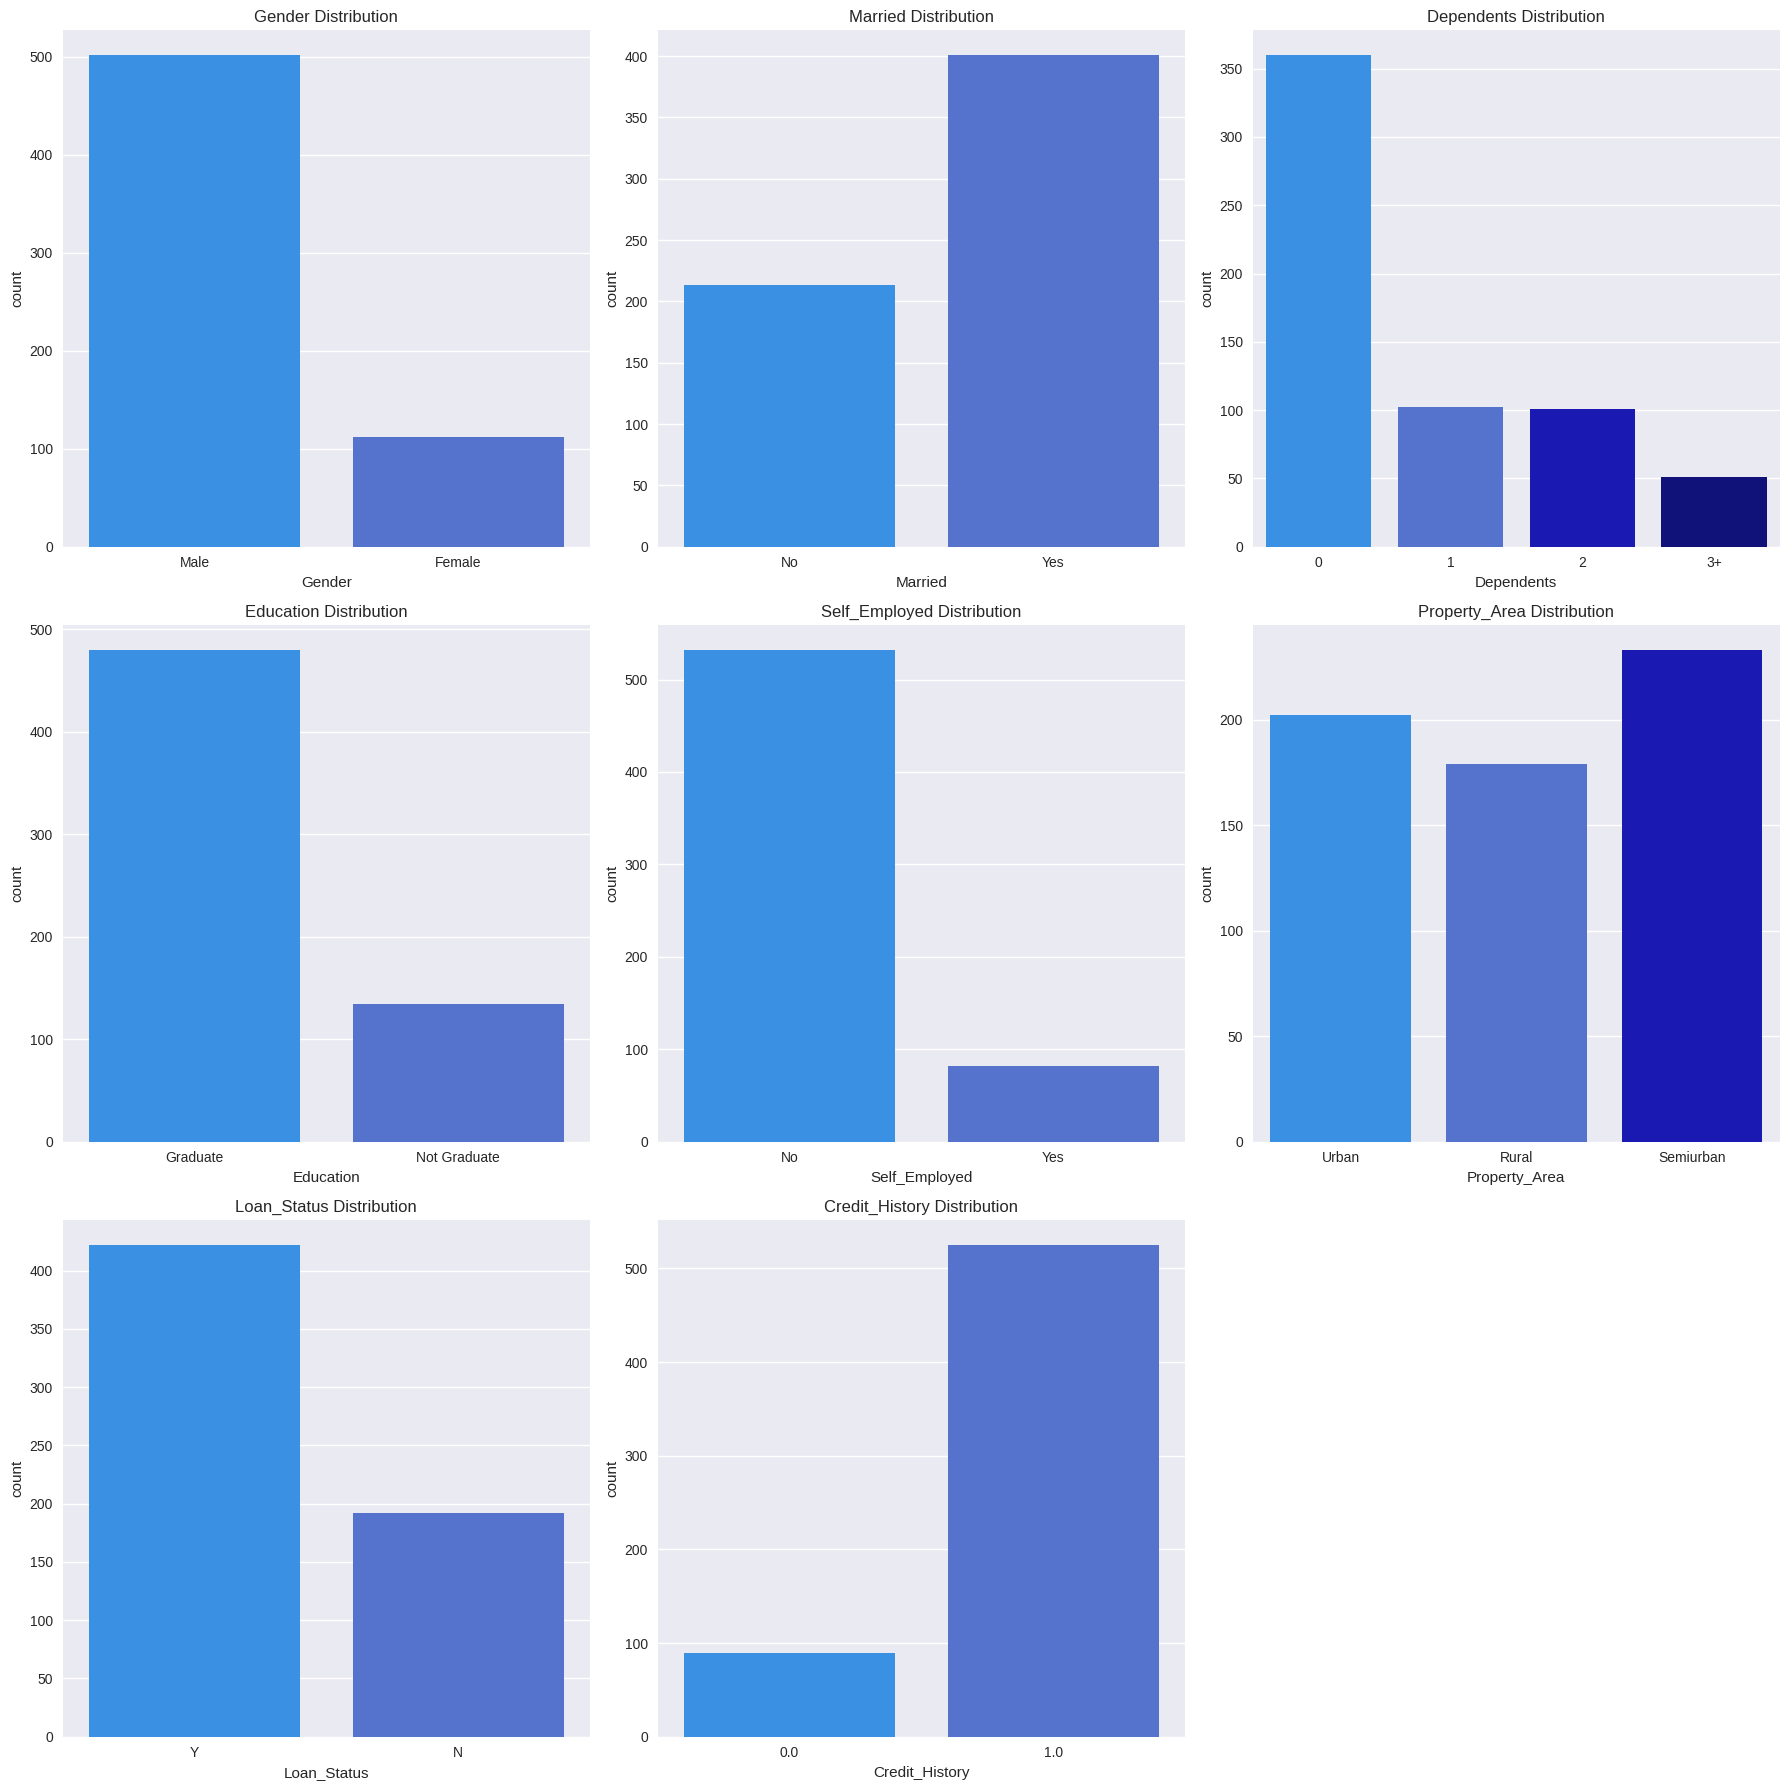

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# Định nghĩa bốn tông màu xanh dương khác nhau từ nhạt đến đậm
blue_palette = [
    '#1e90ff',   # Dodger Blue (nhạt nhất)
    '#4169e1',   # Royal Blue
    '#0000cd',    # Medium Blue
    '#00008b'   # Dark Blue(đậm nhất)
]

for ax, var, title in zip(axes.flatten(), categorical_vars, categorical_vars):
    sns.countplot(ax=ax, x=var, data=df_model, palette = blue_palette)
    ax.set_title(f'{title} Distribution')

# Ẩn các ô trống
axes[2, 2].axis('off')

# Điều chỉnh layout
plt.tight_layout()
plt.show()

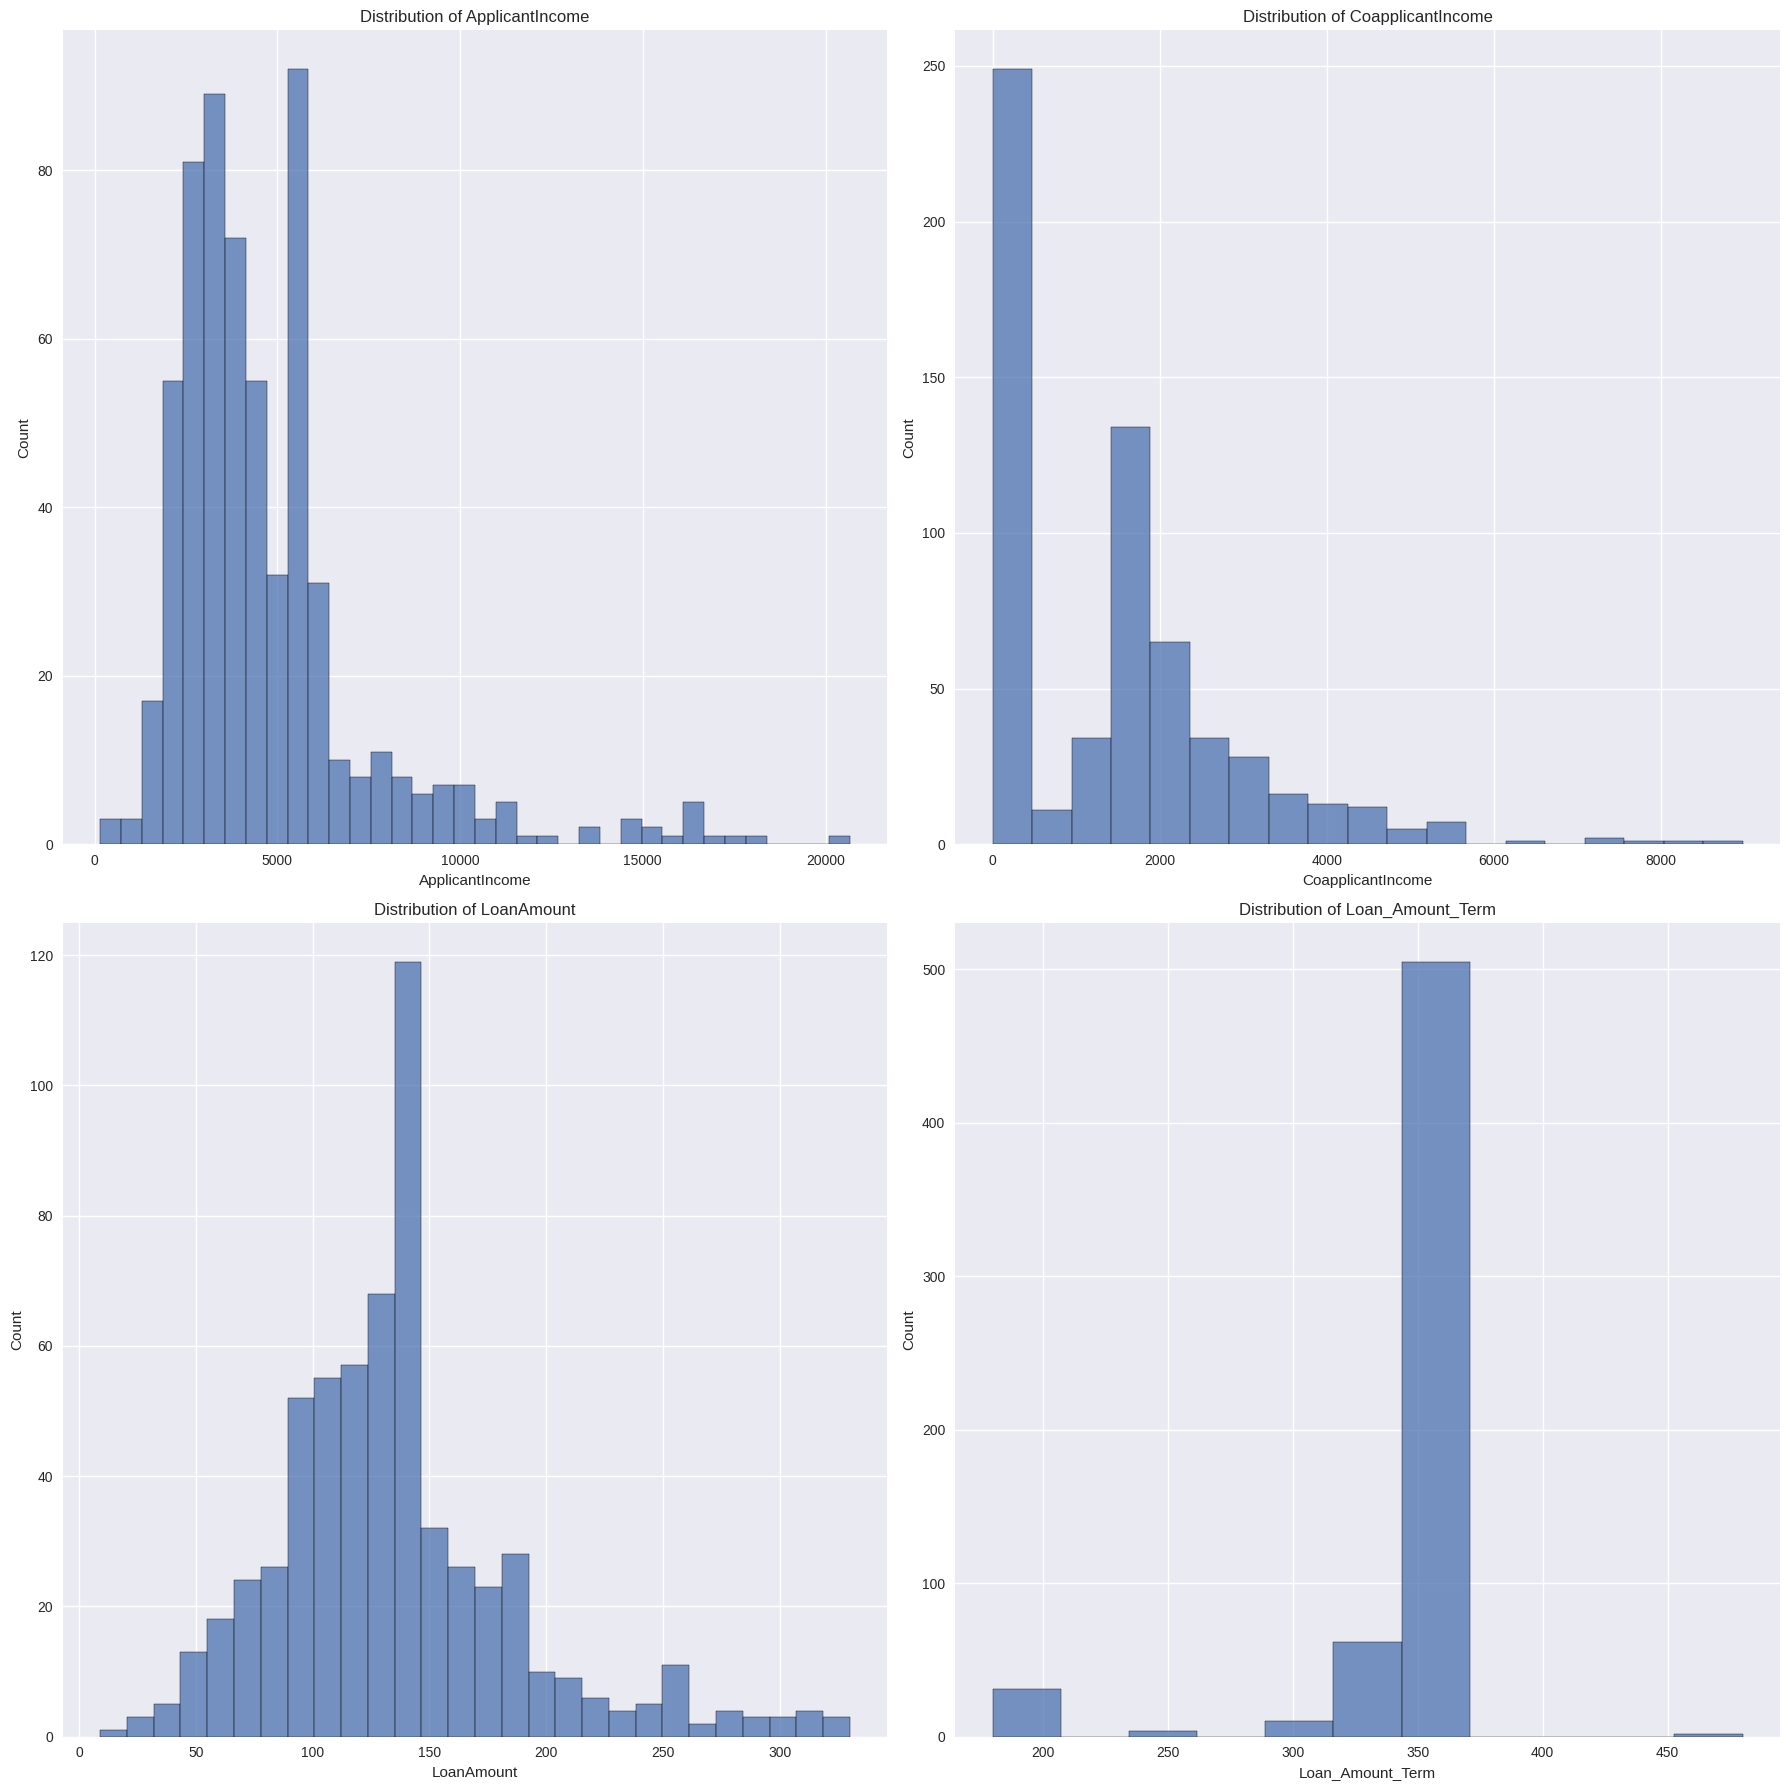

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18, 18))

# Biểu đồ cho biến số
for i, var in enumerate(numerical_vars):
    sns.histplot(ax=axes[i//2, i%2], x=var, data=df_model)
    axes[i//2, i%2].set_title(f'Distribution of {var}')

# Điều chỉnh layout
plt.tight_layout()
plt.show()

## **3. Phân tích tương quan giữa hai biến**

### **3.1 Phân tích tương quan giữa hai biến numberic**

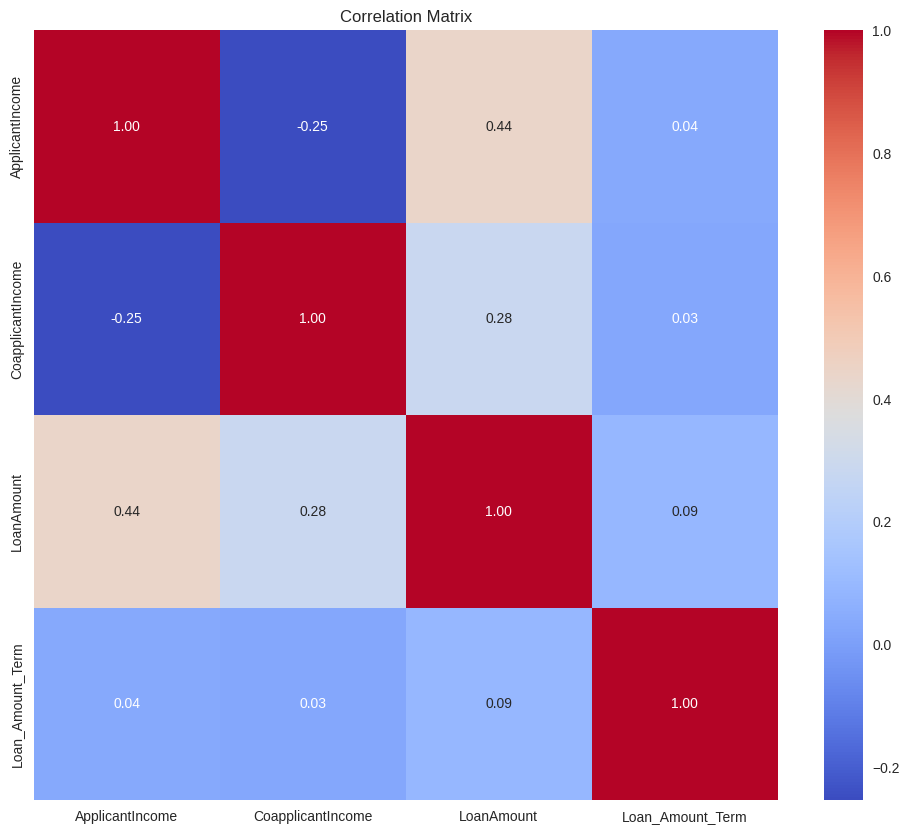

In [ ]:
# Xóa dữ liệu định danh và dữ liệu dạng category
df_corr=df_model[numerical_vars]

# Tính ma trận tương quan
correlation_matrix = df_corr.corr()

# Vẽ ma trận tương quan bằng seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### **3.2 Phân tích tương quan giữa hai biến category**

In [ ]:
import scipy.stats as ss
import numpy as np

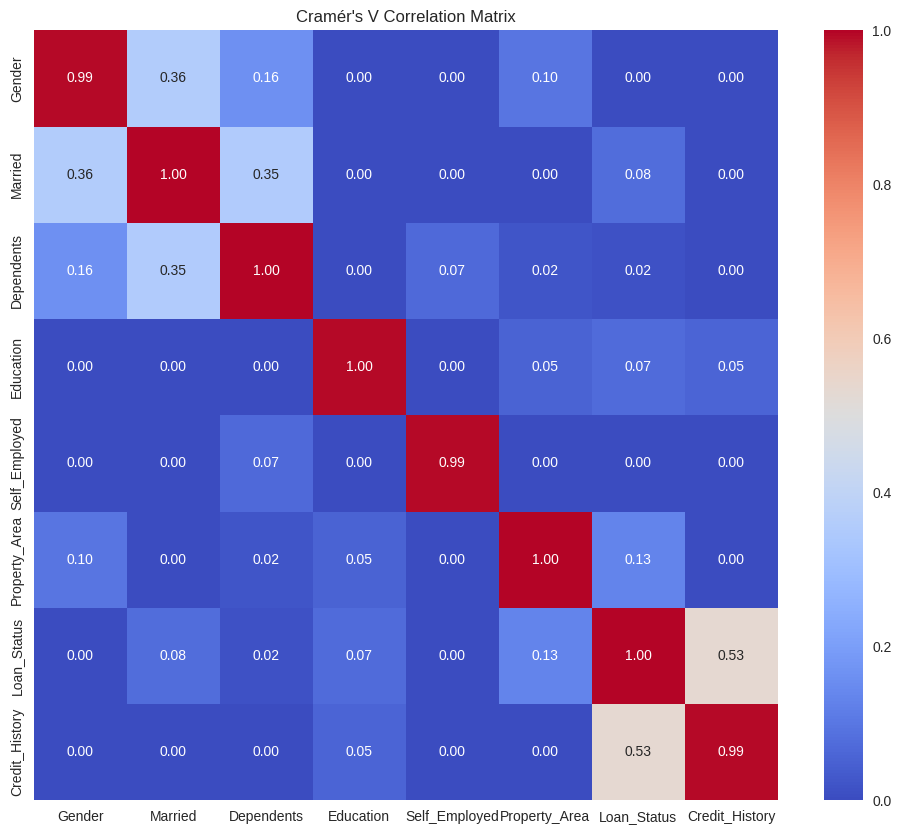

In [ ]:
df_corr = df_model.copy()

#Kiểm định Chi-square và tính Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Tính toán ma trận tương quan giữa các biến phân loại
correlation_matrix = pd.DataFrame(index=categorical_vars, columns=categorical_vars)

for col1 in categorical_vars:
    for col2 in categorical_vars:
        correlation_matrix.loc[col1, col2] = cramers_v(df_corr[col1], df_corr[col2])

correlation_matrix = correlation_matrix.astype(float)

# Hiển thị ma trận tương quan
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Cramér\'s V Correlation Matrix')
plt.show()

### **3.3 Phân tích tương quan giữa hai biến category và numberic**

In [ ]:
from sklearn.preprocessing import LabelEncoder

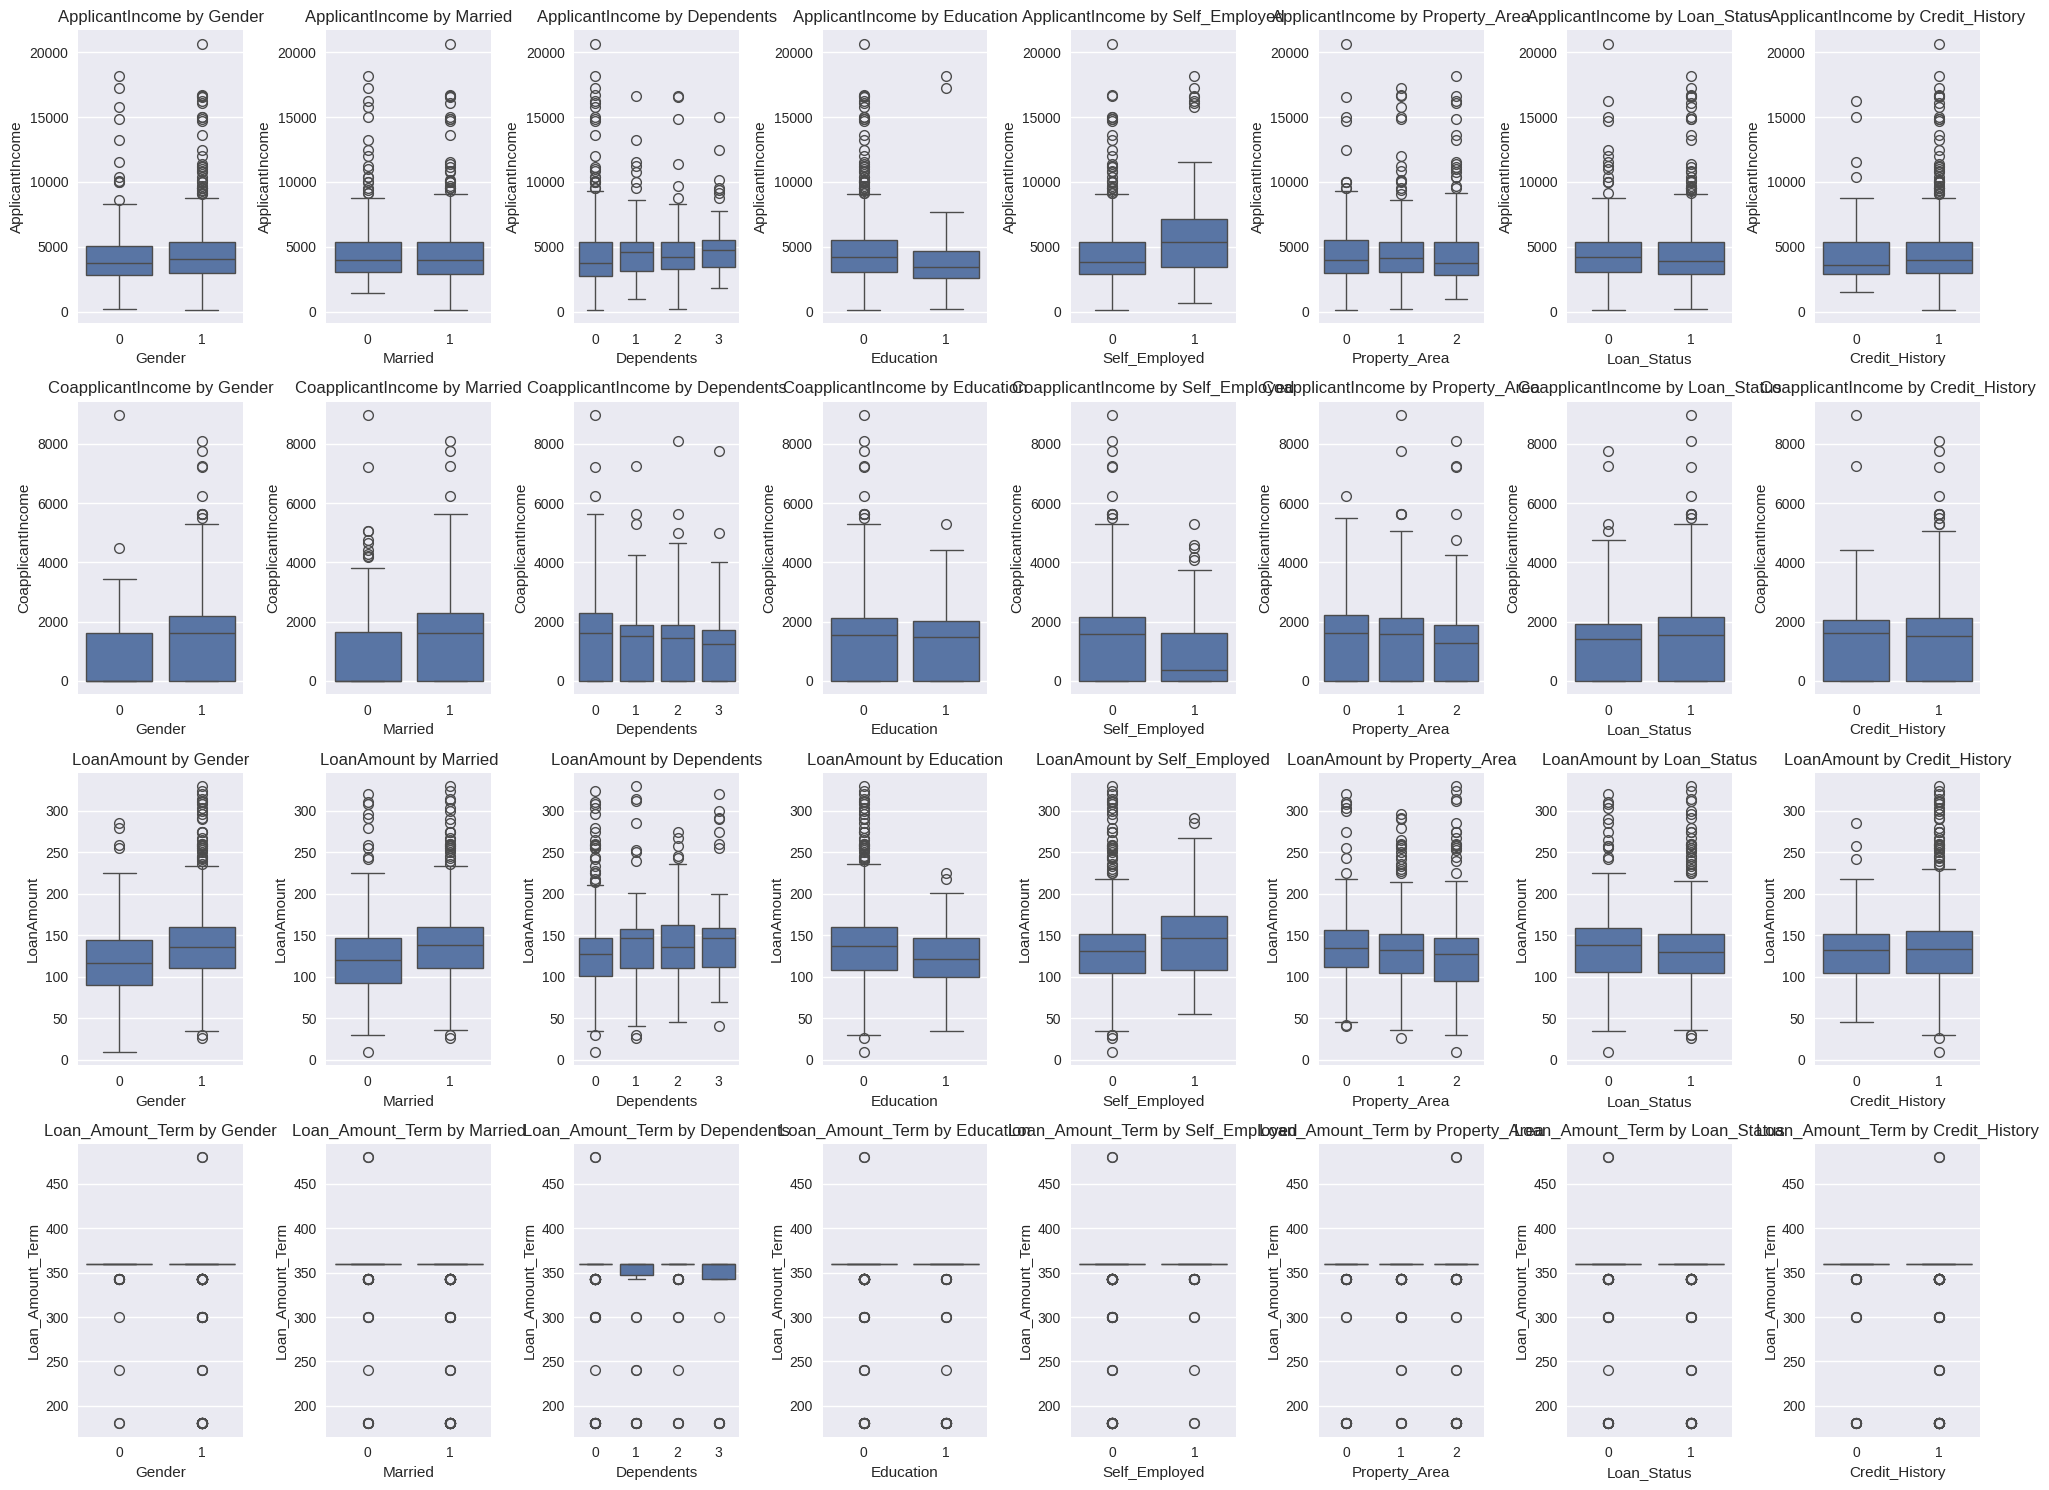

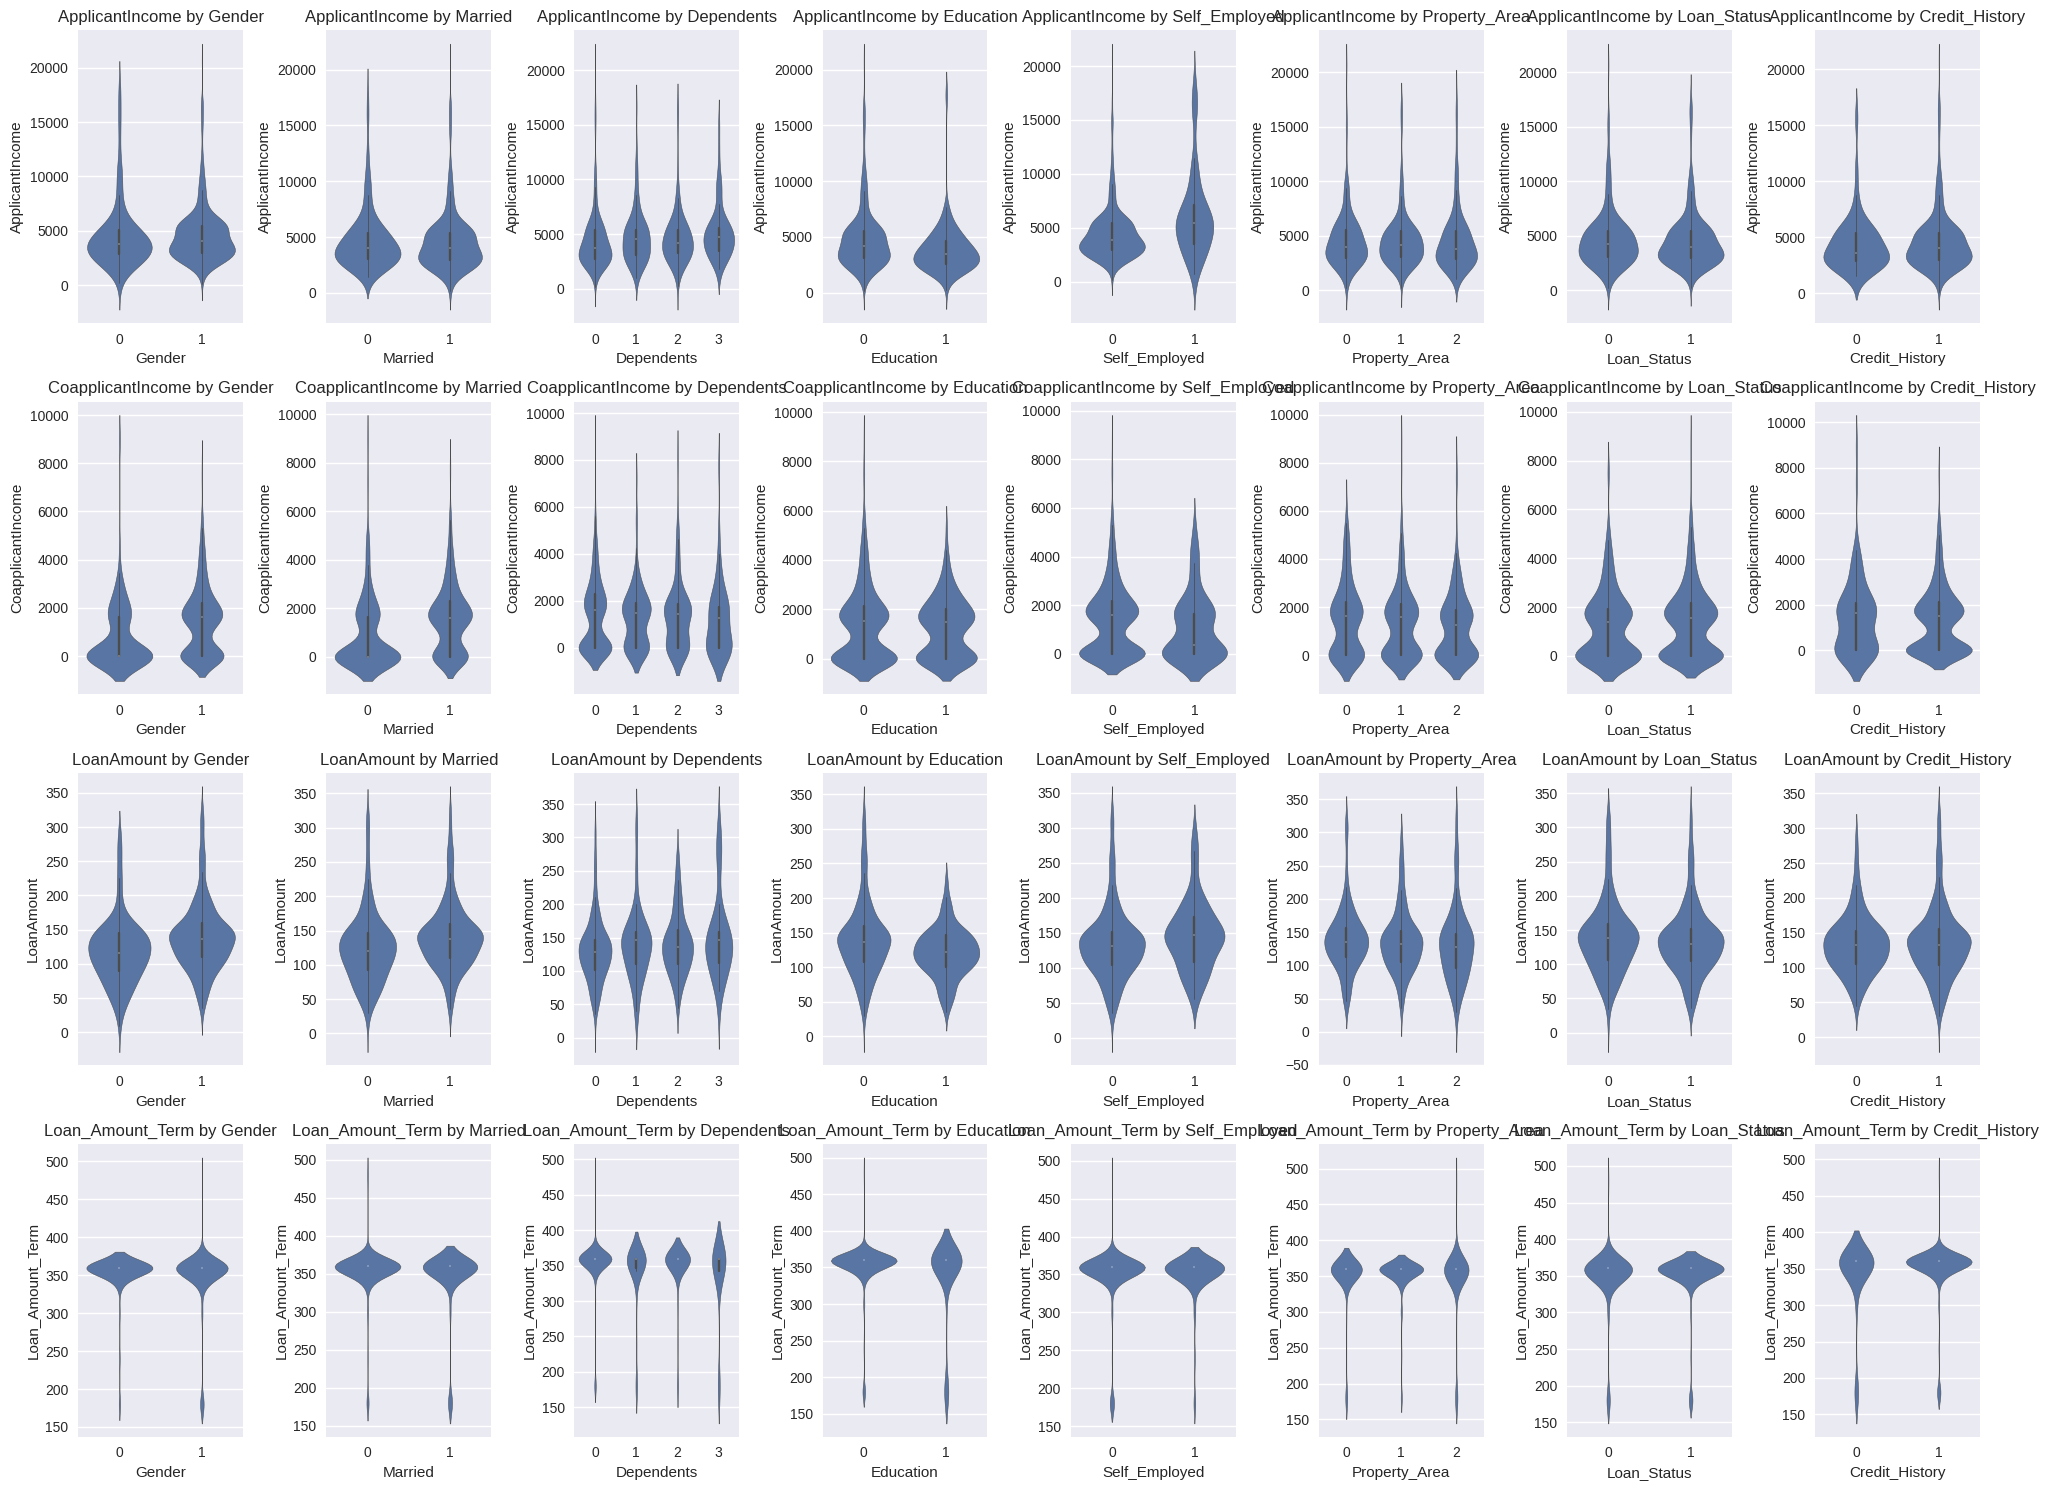

In [ ]:
df_corr = df_model.copy()

# Mã hóa các biến categorical thành số
label_encoders = {}
for column in categorical_vars:
    label_encoders[column] = LabelEncoder()
    df_corr[column] = label_encoders[column].fit_transform(df_corr[column])

# Tạo box plot cho các biến numerical theo từng nhóm của các biến categorical
plt.figure(figsize=(20, 15))

for i, num_var in enumerate(numerical_vars):
    for j, cat_var in enumerate(categorical_vars):
        plt.subplot(len(numerical_vars), len(categorical_vars), i*len(categorical_vars) + j + 1)
        sns.boxplot(x=cat_var, y=num_var, data=df_corr)
        plt.title(f'{num_var} by {cat_var}')
        plt.xlabel(cat_var)
        plt.ylabel(num_var)

plt.tight_layout()
plt.show()

# Tạo violin plot cho các biến numerical theo từng nhóm của các biến categorical
plt.figure(figsize=(20, 15))

for i, num_var in enumerate(numerical_vars):
    for j, cat_var in enumerate(categorical_vars):
        plt.subplot(len(numerical_vars), len(categorical_vars), i*len(categorical_vars) + j + 1)
        sns.violinplot(x=cat_var, y=num_var, data=df_corr)
        plt.title(f'{num_var} by {cat_var}')
        plt.xlabel(cat_var)
        plt.ylabel(num_var)

plt.tight_layout()
plt.show()

### **3.4 Kiểm tra đa cộng tuyến giữa các biến**

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [ ]:
df_corr = df_model.copy().drop(columns=['Loan_Status'])

# Mã hóa các cột phân loại thành số
label_encoders = {}
for column in df_corr.select_dtypes(include=['object']).columns:  # Select object type columns for encoding
    label_encoders[column] = LabelEncoder()
    df_corr[column] = label_encoders[column].fit_transform(df_corr[column])

# Tính VIF cho các biến độc lập
X = add_constant(df_corr)
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

             Variable        VIF
0               const  94.487490
1              Gender   1.190019
2             Married   1.326372
3          Dependents   1.171455
4           Education   1.073565
5       Self_Employed   1.056073
6     ApplicantIncome   1.612291
7   CoapplicantIncome   1.429678
8          LoanAmount   1.615940
9    Loan_Amount_Term   1.052321
10     Credit_History   1.013747
11      Property_Area   1.016253


# **III. Modeling**

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
df_train = df_model.copy()

In [ ]:
# Mã hóa các cột phân loại thành số
label_encoders = {}
for column in df_model.select_dtypes(include=['object']).columns:  # Select object type columns for encoding
    label_encoders[column] = LabelEncoder()
    df_model[column] = label_encoders[column].fit_transform(df_model[column])

In [ ]:
# Xác định biến đầu vào (features) và biến mục tiêu (target)
X = df_model.drop(columns=['Loan_Status'])
y = df_model['Loan_Status']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## **3.1 Logistic Regresstion**

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# Tạo và huấn luyện mô hình Logistic Regression
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Xác định siêu tham số cần tinh chỉnh
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300]
}

# Khởi tạo mô hình Logistic Regression
log_reg = LogisticRegression()

# Khởi tạo GridSearchCV
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Thực hiện tìm kiếm trên tập huấn luyện
grid_search.fit(X_train, y_train)

# In ra các tham số tốt nhất
print("Best parameters:", grid_search.best_params_)

# Dự đoán trên tập kiểm tra
y_pred = grid_search.predict(X_test)

# Đánh giá mô hình
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Y', 'N']))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'C': 1, 'max_iter': 100, 'solver': 'liblinear'}
Accuracy: 0.7837837837837838
              precision    recall  f1-score   support

           Y       0.93      0.42      0.57        65
           N       0.76      0.98      0.86       120

    accuracy                           0.78       185
   macro avg       0.84      0.70      0.71       185
weighted avg       0.82      0.78      0.76       185



## **3.2 Support Vector Machine**

In [ ]:
from sklearn import svm
from sklearn.svm import SVC
from scipy.stats import uniform, loguniform
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Khởi tạo mô hình SVC
svc = svm.SVC()

# Thiết lập các phân phối hoặc danh sách các giá trị tham số cần tối ưu
parameters = {
    'kernel': ['linear', 'rbf'],
    'C': loguniform(1e-2, 1e2),
    'gamma': uniform(0.1, 1.0)
}

# Tạo mô hình Randomized Search với các tham số giới hạn và số lượng thử nghiệm
clf = RandomizedSearchCV(svc, parameters, n_iter=20, cv=5, random_state=42)

# Huấn luyện mô hình Randomized Search trên dữ liệu huấn luyện
clf.fit(X_train, y_train)

# In ra thông số tối ưu và điểm số tốt nhất
print("Best parameters found: ", clf.best_params_)
print("Best score: ", clf.best_score_)

# Dự đoán trên tập kiểm tra
y_pred = clf.predict(X_test)

# Đánh giá mô hình trên tập kiểm tra
print("\nAccuracy:", clf.score(X_test, y_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Y', 'N']))

Best parameters found:  {'C': 0.21618942406574443, 'gamma': 0.2428668179219408, 'kernel': 'linear'}
Best score:  0.7994801641586867

Accuracy: 0.7621621621621621

Classification Report:
              precision    recall  f1-score   support

           Y       0.96      0.34      0.50        65
           N       0.73      0.99      0.84       120

    accuracy                           0.76       185
   macro avg       0.85      0.67      0.67       185
weighted avg       0.81      0.76      0.72       185



## **3.3 Random Forest CLassifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [ ]:
# Xác định siêu tham số cần tinh chỉnh
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Khởi tạo GridSearchCV với Random Forest
grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=2)

# Tiến hành tìm kiếm trên tập huấn luyện
grid_search.fit(X_train, y_train)

# In ra các siêu tham số tốt nhất
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Sử dụng mô hình với các siêu tham số tốt nhất
best_rf_model = grid_search.best_estimator_

# Dự đoán trên tập kiểm tra
y_pred = best_rf_model.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred, target_names=['Y', 'N']))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.7837837837837838
              precision    recall  f1-score   support

           Y       0.90      0.43      0.58        65
           N       0.76      0.97      0.85       120

    accuracy                           0.78       185
   macro avg       0.83      0.70      0.72       185
weighted avg       0.81      0.78      0.76       185



## **3.4 XG Boosting**

In [ ]:
import xgboost as xgb

In [ ]:
# Khởi tạo mô hình XGBoost
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Thiết lập các tham số cần tối ưu
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8]
}

# Tạo mô hình GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)

# Huấn luyện mô hình GridSearchCV
grid_search.fit(X_train, y_train)

# In ra thông số tối ưu và điểm số tốt nhất
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Dự đoán trên tập kiểm tra
y_pred = grid_search.predict(X_test)

# Đánh giá mô hình
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Y', 'N']))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best score:  0.8204651162790698
Accuracy: 0.7837837837837838
Classification Report:
              precision    recall  f1-score   support

           Y       0.93      0.42      0.57        65
           N       0.76      0.98      0.86       120

    accuracy                           0.78       185
   macro avg       0.84      0.70      0.71       185
weighted avg       0.82      0.78      0.76       185



## **3.5 Oversampling**

In [ ]:
from sklearn.utils import resample

# Tìm số lượng mẫu nhiều nhất trong các lớp
max_samples = df_model['Loan_Status'].value_counts().max()

# Oversampling các lớp thiểu số để làm cho số lượng mẫu cân bằng
df_balanced = pd.concat([
    resample(df_model[df_model['Loan_Status'] == 1], replace=True, n_samples=max_samples, random_state=42),
    resample(df_model[df_model['Loan_Status'] == 0], replace=True, n_samples=max_samples, random_state=42)
])

# Xáo trộn lại dữ liệu (nếu cần)
df_balanced = df_balanced.sample(frac=1, random_state=42)

# Kiểm tra số lượng mẫu sau khi cân bằng
print(df_balanced['Loan_Status'].value_counts())

Loan_Status
0    422
1    422
Name: count, dtype: int64


In [ ]:
# Xác định biến đầu vào (features) và biến mục tiêu (target)
X = df_balanced.drop(columns=['Loan_Status'])
y = df_balanced['Loan_Status']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### **a. Logistic Regresstion**

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# Tạo và huấn luyện mô hình Logistic Regression
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Xác định siêu tham số cần tinh chỉnh
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300]
}

# Khởi tạo mô hình Logistic Regression
log_reg = LogisticRegression()

# Khởi tạo GridSearchCV
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Thực hiện tìm kiếm trên tập huấn luyện
grid_search.fit(X_train, y_train)

# In ra các tham số tốt nhất
print("Best parameters:", grid_search.best_params_)

# Dự đoán trên tập kiểm tra
y_pred = grid_search.predict(X_test)

# Đánh giá mô hình
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Y', 'N']))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'C': 0.1, 'max_iter': 100, 'solver': 'liblinear'}
Accuracy: 0.7244094488188977
              precision    recall  f1-score   support

           Y       0.83      0.57      0.68       128
           N       0.67      0.88      0.76       126

    accuracy                           0.72       254
   macro avg       0.75      0.73      0.72       254
weighted avg       0.75      0.72      0.72       254



### **b. Support Vector Machine**

In [ ]:
from sklearn import svm
from sklearn.svm import SVC
from scipy.stats import uniform, loguniform
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Khởi tạo mô hình SVC
svc = svm.SVC()

# Thiết lập các phân phối hoặc danh sách các giá trị tham số cần tối ưu
parameters = {
    'kernel': ['linear', 'rbf'],
    'C': loguniform(1e-2, 1e2),
    'gamma': uniform(0.1, 1.0)
}

# Tạo mô hình Randomized Search với các tham số giới hạn và số lượng thử nghiệm
clf = RandomizedSearchCV(svc, parameters, n_iter=20, cv=5, random_state=42)

# Huấn luyện mô hình Randomized Search trên dữ liệu huấn luyện
clf.fit(X_train, y_train)

# In ra thông số tối ưu và điểm số tốt nhất
print("Best parameters found: ", clf.best_params_)
print("Best score: ", clf.best_score_)

# Dự đoán trên tập kiểm tra
y_pred = clf.predict(X_test)

# Đánh giá mô hình trên tập kiểm tra
print("\nAccuracy:", clf.score(X_test, y_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Y', 'N']))

Best parameters found:  {'C': 2.801635158716261, 'gamma': 0.23949386065204184, 'kernel': 'rbf'}
Best score:  0.859322033898305

Accuracy: 0.8818897637795275

Classification Report:
              precision    recall  f1-score   support

           Y       0.99      0.77      0.87       128
           N       0.81      0.99      0.89       126

    accuracy                           0.88       254
   macro avg       0.90      0.88      0.88       254
weighted avg       0.90      0.88      0.88       254



### **c. Random Forest CLassifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [ ]:
# Xác định siêu tham số cần tinh chỉnh
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Khởi tạo GridSearchCV với Random Forest
grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=2)

# Tiến hành tìm kiếm trên tập huấn luyện
grid_search.fit(X_train, y_train)

# In ra các siêu tham số tốt nhất
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Sử dụng mô hình với các siêu tham số tốt nhất
best_rf_model = grid_search.best_estimator_

# Dự đoán trên tập kiểm tra
y_pred = best_rf_model.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred, target_names=['Y', 'N']))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.8937007874015748
              precision    recall  f1-score   support

           Y       0.92      0.87      0.89       128
           N       0.87      0.92      0.90       126

    accuracy                           0.89       254
   macro avg       0.89      0.89      0.89       254
weighted avg       0.89      0.89      0.89       254



In [ ]:
# Các siêu tham số tốt nhất tìm thấy từ GridSearchCV
best_params = {
    'max_depth': None,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 100
}

# Tạo mô hình RandomForestClassifier với các siêu tham số tốt nhất
rf_best = RandomForestClassifier(**best_params, random_state=42)

# Huấn luyện mô hình với dữ liệu
rf_best.fit(X_train, y_train)

# Dự đoán với tập dữ liệu kiểm tra
y_pred = rf_best.predict(X_test)

# Đánh giá mô hình
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       128
           1       0.87      0.92      0.90       126

    accuracy                           0.89       254
   macro avg       0.89      0.89      0.89       254
weighted avg       0.89      0.89      0.89       254



### **d. XG Boosting**

In [ ]:
import xgboost as xgb

In [ ]:
# Khởi tạo mô hình XGBoost
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Thiết lập các siêu tham số cần tối ưu
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

# Tạo mô hình GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)

# Huấn luyện mô hình GridSearchCV
grid_search.fit(X_train, y_train)

# In ra thông số tối ưu và điểm số tốt nhất
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Dự đoán trên tập kiểm tra
y_pred = grid_search.predict(X_test)

# Đánh giá mô hình
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Y', 'N']))

Fitting 5 folds for each of 7776 candidates, totalling 38880 fits
Best parameters found:  {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 1.5, 'subsample': 0.8}
Best score:  0.8728813559322035
Accuracy: 0.9015748031496063
Classification Report:
              precision    recall  f1-score   support

           Y       0.93      0.88      0.90       128
           N       0.88      0.93      0.90       126

    accuracy                           0.90       254
   macro avg       0.90      0.90      0.90       254
weighted avg       0.90      0.90      0.90       254



In [ ]:
# Các siêu tham số tốt nhất tìm thấy từ GridSearchCV
best_params = {
    'colsample_bytree': 0.7,
    'gamma': 0,
    'learning_rate': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'n_estimators': 200,
    'reg_alpha': 0.1,
    'reg_lambda': 1.5,
    'subsample': 0.8
}

# Tạo mô hình XGBoost với các siêu tham số tốt nhất
xgb_best = xgb.XGBClassifier(**best_params)

# Huấn luyện mô hình với dữ liệu của bạn
xgb_best.fit(X_train, y_train)

# Dự đoán với tập dữ liệu kiểm tra
y_pred = xgb_best.predict(X_test)

# Đánh giá mô hình
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87       128
           1       0.86      0.87      0.87       126

    accuracy                           0.87       254
   macro avg       0.87      0.87      0.87       254
weighted avg       0.87      0.87      0.87       254



# **IV. Pipeline**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')  # Tắt tất cả các cảnh báo

In [ ]:
#Nhập dữ liệu.
df_test = pd.read_csv(r'/content/test.csv')
df_train = pd.read_csv(r'/content/train.csv')

In [ ]:
class Data_PreProcessing(BaseEstimator, TransformerMixin):
    def __init__(self):
      # Khởi tạo các thư viện và biến cần thiết
      self.f1score = None
      self.imputer = SimpleImputer(strategy='mean')
      self.scaler = StandardScaler()
      self.label_encoders = {}
      self.iso_forest = IsolationForest(contamination=0.1)  # contamination là tỷ lệ dự kiến của outlier
      self.outliers = None

    def fit(self, X, y):
      categorical_vars = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Credit_History']
      numerical_vars = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
      target_var = ['Loan_Status']

      # Chỉ giữ lại các cột cần thiết
      relevant_columns = categorical_vars + numerical_vars + target_var
      df_model = pd.concat([X, pd.Series(y, name='Loan_Status')], axis=1)
      df_model = df_model[relevant_columns]

      # Huấn luyện và áp dụng SimpleImputer
      df_imputed = self.imputer.fit_transform(df_model[numerical_vars])
      df_model[numerical_vars] = df_imputed

      # Chuẩn hóa dữ liệu số
      df_numerical_scaled = self.scaler.fit_transform(df_model[numerical_vars])
      df_numerical_scaled = pd.DataFrame(df_numerical_scaled, columns=numerical_vars)

      # Mã hóa biến phân loại
      for column in categorical_vars:
        self.label_encoders[column] = LabelEncoder()
        df_model[column] = self.label_encoders[column].fit_transform(df_model[column])

      # Xử lý outliers bằng Isolation Forest
      outlier_predictions = self.iso_forest.fit_predict(df_numerical_scaled)
      self.outliers = outlier_predictions == -1

      # Thay thế outliers bằng giá trị trung bình
      for column in numerical_vars:
        mean_value = df_model[column].mean()
        df_model.loc[self.outliers, column] = mean_value

      X = df_model.drop(columns=['Loan_Status'])
      y = df_model['Loan_Status']

      # Chia dữ liệu thành tập huấn luyện và tập kiểm tra
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

      # Khởi tạo và huấn luyện mô hình RandomForestClassifier
      model = RandomForestClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100)
      model.fit(X_train, y_train)

      # Dự đoán trên tập kiểm tra
      y_test_pred = model.predict(X_test)

      # Tính toán F1-score cho nhãn 'Y'
      self.f1score_Y = f1_score(y_test, y_test_pred, pos_label='Y')
      print("F1-score for label 'Y':", self.f1score_Y)

      # Tính toán F1-score cho nhãn 'N'
      self.f1score_N = f1_score(y_test, y_test_pred, pos_label='N')
      print("F1-score for label 'N':", self.f1score_N)

      return self

    def transform (self, X):
      categorical_vars = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Credit_History']
      numerical_vars = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

      # Chỉ giữ lại các cột cần thiết
      relevant_columns = categorical_vars + numerical_vars
      df_model = X[relevant_columns]

      # Huấn luyện và áp dụng SimpleImputer
      df_imputed = self.imputer.fit_transform(df_model[numerical_vars])
      df_model[numerical_vars] = df_imputed

      # Chuẩn hóa dữ liệu số
      df_numerical_scaled = self.scaler.fit_transform(df_model[numerical_vars])
      df_numerical_scaled = pd.DataFrame(df_numerical_scaled, columns=numerical_vars)

      # Mã hóa biến phân loại
      for column in categorical_vars:
        self.label_encoders[column] = LabelEncoder()
        df_model[column] = self.label_encoders[column].fit_transform(df_model[column])

      X = df_model.copy()
      return X

In [ ]:
model_3steps = Pipeline(steps=[('Pre_Processing', Data_PreProcessing()),
                              ('Scale_data', StandardScaler()),
                              ('Random_Forest model', RandomForestClassifier(max_depth = 20, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 100))])

In [ ]:
X_train = df_train.drop(columns=['Loan_Status'])
y_train = df_train['Loan_Status']

In [ ]:
model_3steps.fit(X_train, y_train)

F1-score for label 'Y': 0.8461538461538461
F1-score for label 'N': 0.5625000000000001


Pipeline(steps=[('Pre_Processing', Data_PreProcessing()),
                ('Scale_data', StandardScaler()),
                ('Random_Forest model', RandomForestClassifier(max_depth=20))])

In [ ]:
X_test = df_test.copy()
result = model_3steps.predict(X_test)

In [ ]:
print(result )

['Y' 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'Y'
 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'N'
 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y'
 'Y' 'N' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'N' 'N' 'Y' 'N' 'Y' 'Y'
 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'N' 'Y' 'N' 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'N'
 'Y' 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'N' 'Y' 'N' 'Y' 'Y' 'N' 'Y'
 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'N' 'N' 'N' 'N' 'Y' 'Y' 'Y' 'N' 'N' 'Y'
 'N' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'N' 'Y' 'N' 'Y'
 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'N'
 'Y' 'Y' 'Y' 'N' 'N' 'Y' 'N' 'N' 'Y' 'Y' 'Y' 'N' 'N' 'Y' 'Y' 'Y' 'Y' 'Y'
 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'N' 'N' 'Y' 'Y' 'N' 'Y'
 'N' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'Y'
 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'Y' 'Y'
 'Y' 'N' 'N' 'Y' 'Y' 'N' 'Y' 'N' 'Y' 'N' 'Y' 'N' 'Y

In [ ]:
# Đảm bảo rằng chiều dài của result khớp với số hàng của df_test
assert len(result) == len(df_test), "Chiều dài của kết quả dự đoán không khớp với số hàng của df_test"

# Thêm cột 'Loan_Status_Predicted' vào df_test để lưu trữ kết quả dự đoán
df_test['Loan_Status_Predicted'] = result

# Ánh xạ giá trị 1 về 'Y' và 0 về 'N'
df_test['Loan_Status_Predicted'] = df_test['Loan_Status_Predicted'].map({'Y': 'Accepted', 'N': 'Not Accepted'})

In [ ]:
df_test['Loan_Status_Predicted'].value_counts()

Loan_Status_Predicted
Accepted        301
Not Accepted     66
Name: count, dtype: int64

In [ ]:
X_test = df_test.head(1)
result = model_3steps.predict(X_test)
print(result)

['N']
